# Benchmarking Various File Types

In order to obtain a complete investigation for the report, the metrics obtained will be referencing generated synthetic data.

In [1]:
import os
import time
import json
import h5py
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

### Generating Data to Write to Files
To benchmark write times as a function of data shape, a function was created to generate arbitrary data and will be used to write to the 4 files.

In [2]:
def generate_data(num_rows, num_cols):
    np.random.seed(42) 
    data = {}
    for i in range(0, num_cols):
        if i%2 == 0:
            data[f"int_col_{i}"] = np.random.randint(1000, 5000, size=num_rows)
        else:
            data[f"float_col_{i}"] = np.random.uniform(0, 1, size=num_rows)
    return pd.DataFrame(data)

### Write Functions for Benchmarking

Below these functions were written to replicate how the DAQ computer would recieve and write data.

In [ ]:
def write_csv(file_path, data):
    data_string = data.to_csv(index=False, header=False)
    times = []
    fake_sent_data = data_string.split("\n")
    with open(file_path, "w") as f_csv:
        for line in fake_sent_data:
            start_time = time.time()
            f_csv.write(line+"\n")
            end_time = time.time()
            times.append(end_time - start_time)
    return np.sum(times)

def write_json(file_path, data):
    data_list = data.to_dict(orient="records")
    start_time = time.time()
    with open(file_path, "w") as f:
        json.dump(data_list, f)
    return time.time() - start_time

def write_bin(file_path, data):
    data_list = data.to_dict(orient="records")
    start_time = time.time()
    with open(file_path, "wb") as bin_file:
        pickle.dump(data_list, bin_file)
    
    return time.time() - start_time

def write_struct_bin2(file_path, data):
    data = data.to_numpy()
    times = np.zeros(len(data))
    with open(file_path, "wb") as bin_file:
        i = 0
        for row in data:
            timestamp_b = struct.pack("<I", int(row[0]))
            temperature_b = struct.pack("<d", float(row[1]))
            start_time = time.time()
            bin_file.write(timestamp_b)
            bin_file.write(temperature_b)
            end_time = time.time()
            times[i] = end_time - start_time
            i+=1
    return np.sum(times)

def write_struct_bin3(file_path, data):
    data = data.to_numpy()
    times = np.zeros(len(data))
    with open(file_path, "wb") as bin_file:
        i=0
        for row in data:
            timestamp_b = struct.pack("<I", int(row[0]))
            temperature_b = struct.pack("<d", float(row[1]))
            clockspeed_b = struct.pack("<I", int(row[2]))
            start_time = time.time()
            bin_file.write(timestamp_b)
            bin_file.write(temperature_b)
            bin_file.write(clockspeed_b)
            end_time = time.time()
            times[i] = end_time - start_time
            i+=1
    return np.sum(times)

def write_struct_bin4(file_path, data):
    data = data.to_numpy()
    times = np.zeros(len(data))
    with open(file_path, "wb") as bin_file:
        i = 0
        for row in data:
            timestamp_b = struct.pack("<I", int(row[0]))
            temperature_b = struct.pack("<d", float(row[1]))
            clockspeed_b = struct.pack("<I", int(row[2]))
            voltage_b = struct.pack("<d", float(row[3]))
            start_time = time.time()
            bin_file.write(timestamp_b)
            bin_file.write(temperature_b)
            bin_file.write(clockspeed_b)
            bin_file.write(voltage_b)
            end_time = time.time()
            times[i] = end_time - start_time
            i+=1
    return np.sum(times)


def write_hdf5(file_path, data):
    start_time = time.time()
    with h5py.File(file_path, "w") as f:
        for col in data.columns:
            f.create_dataset(col, data=data[col].values)
    return time.time() - start_time

def benchmark_write(file_path, file_format, data):
    return write_functions[file_format](file_path, data)

write_functions = {
    "CSV": write_csv,
    "JSON": write_json,
    "BIN": write_bin,
    "H5": write_hdf5,
    "BIN_struct2": write_struct_bin2,
    "BIN_struct3": write_struct_bin3,
    "BIN_struct4": write_struct_bin4
}

In [ ]:
output_folder = "../../arbitrary_data/"

rows = np.arange(5000, 100000, 5000)
rows[0] = 100000
rows = np.roll(rows, -1) # rotate the positions of all items in rows backwards

# Dictionaries that store write times depending on column size
write_times2 = {"CSV": [], "JSON": [], "BIN": [], "H5": [], "BIN_struct": []}
write_times3 = {"CSV": [], "JSON": [], "BIN": [], "H5": [], "BIN_struct": []}
write_times4 = {"CSV": [], "JSON": [], "BIN": [], "H5": [], "BIN_struct": []}

write_times = [write_times2,write_times3,write_times4]

# Generate synthetic data and run benchmark
for col in range(2, 5):
    for num_rows in rows:
        data = generate_data(num_rows, col)
        for file_format in write_functions.keys():
            if "BIN_struct" in file_format:
                if file_format != f"BIN_struct{col}":
                    continue
                else:
                    file_path = os.path.join(output_folder, f"arbitrary_{num_rows}_{col}_struct.bin")
                    file_format = f"BIN_struct{col}"
            else:
                file_path = os.path.join(output_folder, f"arbitrary_{num_rows}_{col}.{file_format.lower()}")
            write_time = benchmark_write(file_path, file_format, data)#
            if "BIN_struct" in file_format:
                file_format = "BIN_struct"
            write_times[col-2][file_format].append(write_time)

display(data)

colsize 2 bin 0.002663135528564453
colsize 2 bin 0.004557132720947266
colsize 2 bin 0.0030438899993896484
colsize 2 bin 0.004628419876098633
colsize 2 bin 0.004639387130737305
colsize 2 bin 0.005077838897705078
colsize 2 bin 0.010953426361083984
colsize 2 bin 0.01102757453918457
colsize 2 bin 0.005328178405761719
colsize 2 bin 0.009087562561035156
colsize 2 bin 0.010834455490112305
colsize 2 bin 0.011735916137695312
colsize 2 bin 0.010100841522216797
colsize 2 bin 0.016963720321655273
colsize 2 bin 0.016821861267089844
colsize 2 bin 0.015624523162841797
colsize 2 bin 0.01910853385925293
colsize 2 bin 0.018678665161132812
colsize 2 bin 0.019818544387817383
colsize 3 bin 0.002501964569091797
colsize 3 bin 0.0035016536712646484
colsize 3 bin 0.004439115524291992
colsize 3 bin 0.008348226547241211
colsize 3 bin 0.004803657531738281
colsize 3 bin 0.006211280822753906
colsize 3 bin 0.009287595748901367
colsize 3 bin 0.0036580562591552734
colsize 3 bin 0.009951591491699219
colsize 3 bin 0.016

,int_col_0,float_col_1,int_col_2,float_col_3
0,4174,0.148037,1472,0.582103
1,4507,0.900659,4145,0.006389
2,1860,0.934853,2728,0.483780
3,2294,0.660610,2099,0.339174
4,2130,0.303155,1361,0.914628
...,...,...,...,...
99995,2149,0.993974,1243,0.400836
99996,3559,0.744981,1621,0.747044
99997,3177,0.439274,4692,0.255281
99998,3755,0.179754,2355,0.757578


In [ ]:
data_to_save = []

for col_size in range(2, 5):
    for i, file_format in enumerate(write_times[col_size - 2].keys()):  # Iterate over file formats in each column size group
        for j, write_time in enumerate(write_times[col_size - 2][file_format]):  # Iterate over write times for each file format
            num_rows = rows[j]
            data_to_save.append([file_format, num_rows, col_size, write_time])

df = pd.DataFrame(data_to_save, columns=["File Type", "Num Rows", "Num Cols", "Write Time (seconds)"])
df["File Type"] = df["File Type"].replace("BIN", "BIN_pickle") #Replace BIN with how binary was implemented
df.to_csv("write_times.csv", index=False) #store data frame in csv file for future reference

### Plotting the Write Times against Shape of Data
#### Entire Dataset

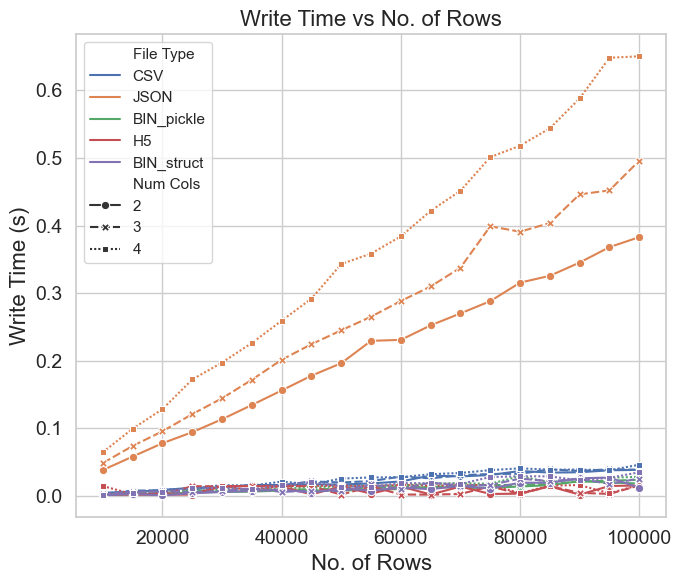

In [ ]:
colours = {"CSV":"tab:blue","JSON":"tab:orange", "BIN_pickle":"tab:green", "H5":"tab:red", "BIN_struct":"tab:purple"} #to ensure colour consistency
plt.figure(figsize = (7,6))
sns.lineplot(data = df, x = "Num Rows", y = "Write Time (seconds)", hue = "File Type", style = "Num Cols", markers = True)
plt.title("Write Time vs No. of Rows", fontsize = 16)
plt.xlabel("No. of Rows", fontsize = 16)
plt.ylabel("Write Time (s)", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Write_Times_vs_Data_Shape.pdf", bbox_inches = "tight", format = "pdf")
plt.show()

#### Filtering out `.json`

`.json` files had a much larger write time. To draw meaningful conclusion from plot, it was filtered out

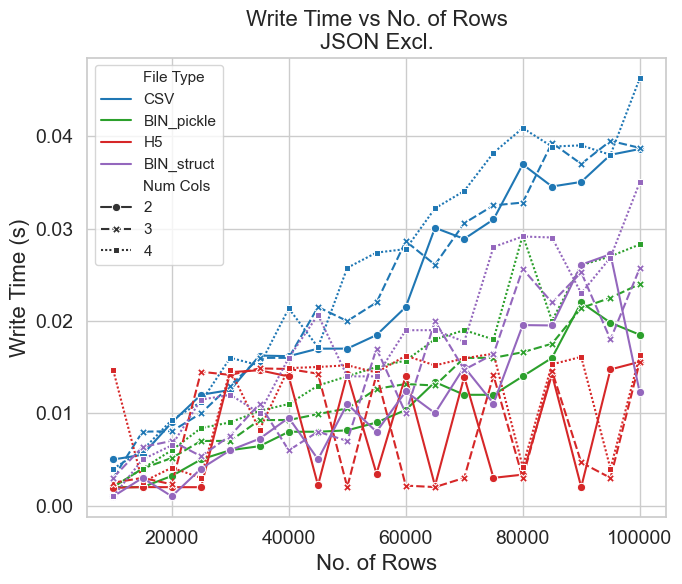

In [ ]:
filtered_df = df[df["File Type"] != "JSON"] #filter out JSON
colours = {"CSV":"tab:blue", "BIN_pickle":"tab:green", "H5":"tab:red", "BIN_struct":"tab:purple"}
plt.figure(figsize = (7,6))
sns.lineplot(data = filtered_df, x = "Num Rows", y = "Write Time (seconds)", hue = "File Type", style = "Num Cols", markers = True, palette = colours)
plt.title("Write Time vs No. of Rows\nJSON Excl.", fontsize = 16)
plt.xlabel("No. of Rows", fontsize = 16)
plt.ylabel("Write Time (s)", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Write_Times_vs_Data_Shape_NO_JSON.pdf", bbox_inches = "tight", format = "pdf")
plt.show()

### Benchmarking Read Times for Each File

Below is functions used to read the data. The philosophy behind the functions development would for the point of view for someone performing data analysis. Hence the fairly extensive use of `Pandas`.

In [ ]:
def read_csv(file_path):
    return pd.read_csv(file_path)

def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

def read_bin(file_path):
    return pd.read_pickle(file_path)

def read_via_struct2(file_path):
    timestamps = []
    temperatures = []
    with open(file_path, "rb") as bin_file:
        while True:
            timestamp_bytes = bin_file.read(4)
            if len(timestamp_bytes) != 4:
                    break
            temperature_bytes = bin_file.read(8)
            timestamp = struct.unpack("<I", timestamp_bytes)[0]
            temperature = struct.unpack("<d", temperature_bytes)[0]
            timestamps.append(timestamp)
            temperatures.append(temperature)
    return pd.DataFrame({"timestamp": timestamps, "raw_adc_reading": temperatures})

def read_via_struct3(file_path):
    timestamps = []
    temperatures = []
    clockspeeds = []
    with open(file_path, "rb") as bin_file:
        while True:
            timestamp_bytes = bin_file.read(4)
            if len(timestamp_bytes) != 4:
                    break
            temperature_bytes = bin_file.read(8)
            clockspeed_bytes = bin_file.read(4)
            timestamp = struct.unpack("<I", timestamp_bytes)[0]
            temperature = struct.unpack("<d", temperature_bytes)[0]
            clockspeed = struct.unpack("<I", clockspeed_bytes)[0]
            timestamps.append(timestamp)
            temperatures.append(temperature)
            clockspeeds.append(clockspeed)
    return pd.DataFrame({"timestamp": timestamps, "raw_adc_reading": temperatures, "clockspeed":clockspeeds})

def read_via_struct4(file_path):
    timestamps = []
    temperatures = []
    clockspeeds = []
    voltages = []
    with open(file_path, "rb") as bin_file:
        while True:
            timestamp_bytes = bin_file.read(4)
            if len(timestamp_bytes) != 4:
                    break
            temperature_bytes = bin_file.read(8)
            clockspeed_bytes = bin_file.read(4)
            voltage_bytes = bin_file.read(8)
            timestamp = struct.unpack("<I", timestamp_bytes)[0]
            temperature = struct.unpack("<d", temperature_bytes)[0]
            clockspeed = struct.unpack("<I", clockspeed_bytes)[0]
            voltage = struct.unpack("<d", voltage_bytes)[0]
            timestamps.append(timestamp)
            temperatures.append(temperature)
            clockspeeds.append(clockspeed)
            voltages.append(voltage)
    return pd.DataFrame({"timestamp": timestamps, "raw_adc_reading": temperatures, "clockspeed":clockspeeds, "voltage":voltages})

def read_hdf5(file_path):
    with h5py.File(file_path, "r") as f:
        return {key: f[key][:] for key in f.keys()}


def benchmark_read_write(file_path, file_format):
    start_time = time.time()
    data = read_functions[file_format](file_path)
    read_time = time.time() - start_time
    return read_time, 0


read_functions = {
    "CSV": read_csv,
    "JSON": read_json,
    "BIN_pickle": read_bin,
    "H5": read_hdf5,
    "BIN_struct2": read_via_struct2,
    "BIN_struct3": read_via_struct3,
    "BIN_struct4": read_via_struct4
}

,file_name,Num Cols,datatype,row_size,read_time
0,arbitrary_100000_2.bin,2,BIN_pickle,100000,0.025826
1,arbitrary_100000_2.csv,2,CSV,100000,0.035520
2,arbitrary_100000_2.h5,2,H5,100000,0.010000
3,arbitrary_100000_2.json,2,JSON,100000,0.076610
4,arbitrary_100000_2_struct.bin,2,BIN_struct,100000,0.067888
...,...,...,...,...,...
280,arbitrary_95000_4.bin,4,BIN_pickle,95000,0.034234
281,arbitrary_95000_4.csv,4,CSV,95000,0.055396
282,arbitrary_95000_4.h5,4,H5,95000,0.010084
283,arbitrary_95000_4.json,4,JSON,95000,0.131552


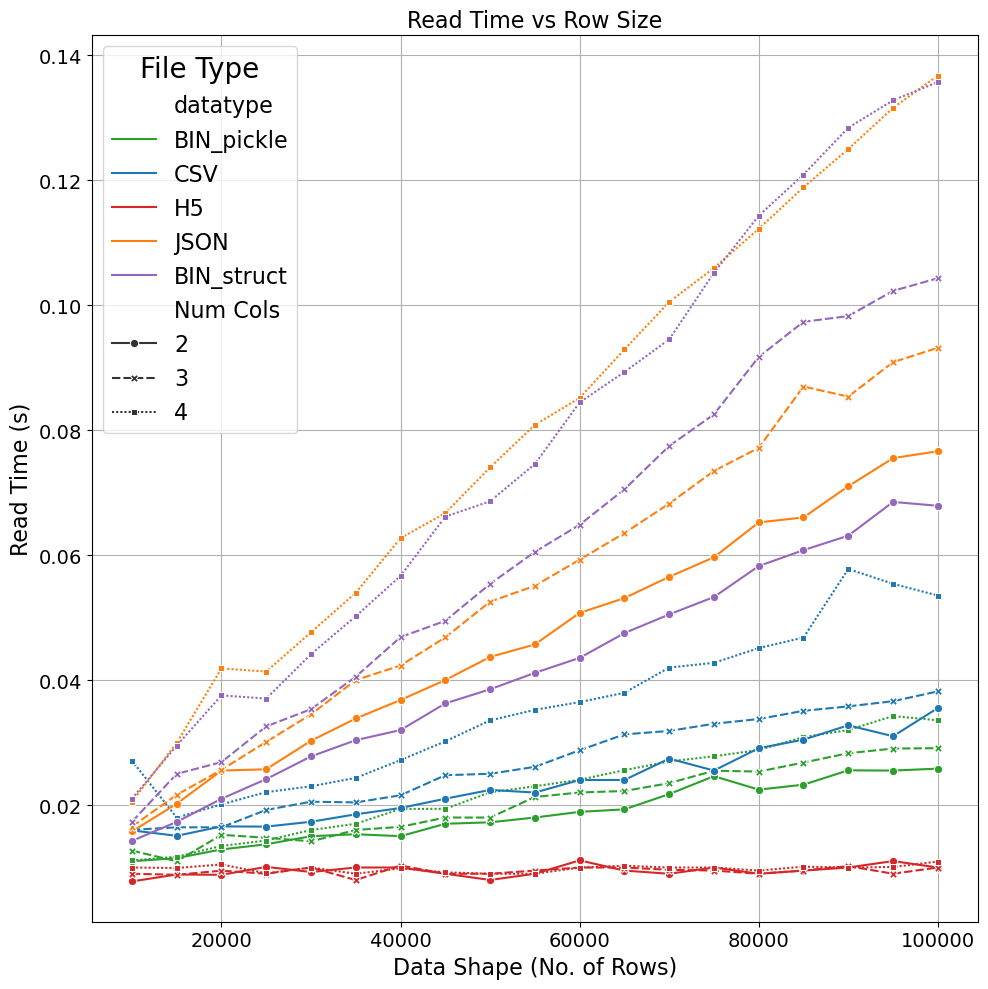

In [ ]:
folder = "../../arbitrary_data"

read_times = {"CSV": [], "JSON": [], "BIN_pickle": [], "H5": [], "BIN_struct":[]}
colsize_n_rowsize = []

for file_name in os.listdir(folder):
    if file_name.endswith((".csv", ".json", ".bin", ".h5")):
        file_path = os.path.join(folder, file_name)

        name_parts = file_name.split('_')
        row_size = int(name_parts[1])
        col_size = int(name_parts[2].split('.')[0])
        file_format = file_name.split('.')[-1].upper()

        if file_format == "BIN" and "struct" in file_name:
            if col_size == 2:
                read_time, write_time = benchmark_read_write(file_path, "BIN_struct2")
                file_format = "BIN_struct"
            elif col_size == 3:
                read_time, write_time = benchmark_read_write(file_path, "BIN_struct3")
                file_format = "BIN_struct"
            elif col_size == 4:
                read_time, write_time = benchmark_read_write(file_path, "BIN_struct4")
                file_format = "BIN_struct"
        elif file_format == "BIN":
            read_time, write_time = benchmark_read_write(file_path, "BIN_pickle")
            file_format = "BIN_pickle"
        else:
            read_time, write_time = benchmark_read_write(file_path, file_format)

        colsize_n_rowsize.append({
            "file_name": file_name,
            "Num Cols": col_size,
            "datatype": file_format,
            "row_size": row_size,
            "read_time": read_time
        })

df = pd.DataFrame(colsize_n_rowsize)

display(df)



In [ ]:
color_palette = {
    "CSV": "tab:blue",
    "JSON": "tab:orange",
    "BIN_pickle": "tab:green",
    "H5": "tab:red",
    "BIN_struct": "tab:purple"
}

plt.figure(figsize = (10,10))
sns.lineplot(data=df, 
                x="row_size", 
                y="read_time", 
                hue="datatype", 
                style="Num Cols", 
                markers = True,
                palette=color_palette
                )

plt.title("Read Time vs Row Size", fontsize = 16)
plt.xlabel("Data Shape (No. of Rows)", fontsize = 16)
plt.ylabel("Read Time (s)", fontsize = 16)
plt.legend(title="File Type", loc="upper left", fontsize = 16, title_fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig("read_times.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

### Benchmarking File Sizes

Investigating how File Size increases as a function of data shape.

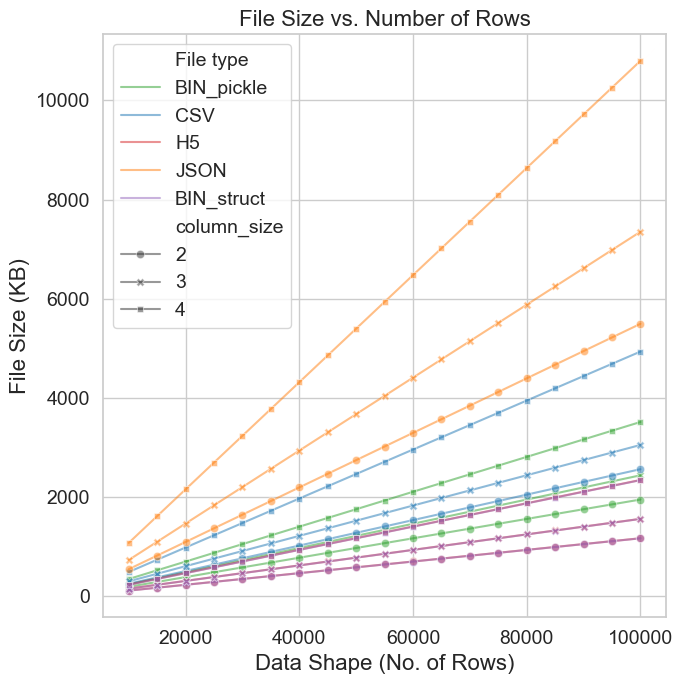

In [ ]:
import os
import h5py

folder = "../../arbitrary_data"

data = []


for file in os.listdir(folder): 
    
    name_parts = file.split('_')
    colsize = int(name_parts[2].split('.')[0])
    filepath = os.path.join(folder, file)
    file_size = os.path.getsize(filepath) / 1024  
    extra_index = 0
    if file.endswith(".csv"):
        df = pd.read_csv(filepath)
        file_type = "csv".upper()
    elif file.endswith(".json"):
        df = pd.read_json(filepath)
        file_type = "json".upper()
    elif file.endswith(".bin"):  
        if "struct" in file:
            file_type = "BIN_struct"
        else:
            file_type = "bin".upper() + "_pickle"
    elif file.endswith(".h5"):
        file_type = "h5".upper()

    num_rows = file.split("_")[1]
    data.append((folder, num_rows, file_size, file_type, colsize))

df_plot = pd.DataFrame(data, columns=["Folder", "Rows", "File Size (KB)", "File type", "column_size"])

df_plot["Rows"] = pd.to_numeric(df_plot["Rows"])
color_palette = {
    "CSV": "tab:blue",
    "JSON": "tab:orange",
    "BIN_pickle": "tab:green",
    "H5": "tab:red",
    "BIN_struct": "tab:purple"
}


plt.figure(figsize=(7, 7))
sns.lineplot(data=df_plot, x="Rows", y="File Size (KB)", hue="File type", style="column_size", markers = True, dashes=False, palette = color_palette, alpha = 0.5)
plt.xlabel("Data Shape (No. of Rows)", fontsize = 16)
plt.ylabel("File Size (KB)", fontsize = 16)
plt.title("File Size vs. Number of Rows", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper left", fontsize = 14, title_fontsize = 16)
plt.savefig("wfile_Right_all.pdf",format = "pdf", bbox_inches = "tight")
plt.show()



### Where is `bin_struct_`???

It's there, the cell below shows that the file size is very similar to `.h5`.

In [33]:
display(df_plot)
df_plot_filtered = df_plot[df_plot["File type"].isin(["BIN_struct", "H5"])]
display(df_plot_filtered)
percentage_diffs = []

for _, group in df_plot_filtered.groupby(["Rows", "column_size"]):
    h5_size = group[group["File type"] == "H5"]["File Size (KB)"].values
    bin_struct_size = group[group["File type"] == "BIN_struct"]["File Size (KB)"].values
    
    if len(h5_size) > 0 and len(bin_struct_size) > 0:
        percentage_diff = ((h5_size[0] - bin_struct_size[0]) / bin_struct_size[0]) * 100
        percentage_diffs.append((group["Rows"].values[0], group["column_size"].values[0], percentage_diff))

percentage_df = pd.DataFrame(percentage_diffs, columns=["Rows", "Column Size", "Percentage Diff"])
display(percentage_df.describe())

,Folder,Rows,File Size (KB),File type,column_size
0,../../arbitrary_data,100000,1953.619141,BIN_pickle,2
1,../../arbitrary_data,100000,2565.264648,CSV,2
2,../../arbitrary_data,100000,1173.875000,H5,2
3,../../arbitrary_data,100000,5494.950195,JSON,2
4,../../arbitrary_data,100000,1171.875000,BIN_struct,2
...,...,...,...,...,...
280,../../arbitrary_data,95000,3340.542969,BIN_pickle,4
281,../../arbitrary_data,95000,4688.673828,CSV,4
282,../../arbitrary_data,95000,2230.562500,H5,4
283,../../arbitrary_data,95000,10255.078125,JSON,4


,Folder,Rows,File Size (KB),File type,column_size
2,../../arbitrary_data,100000,1173.87500,H5,2
4,../../arbitrary_data,100000,1171.87500,BIN_struct,2
7,../../arbitrary_data,100000,1564.50000,H5,3
9,../../arbitrary_data,100000,1562.50000,BIN_struct,3
12,../../arbitrary_data,100000,2347.75000,H5,4
...,...,...,...,...,...
274,../../arbitrary_data,95000,1113.28125,BIN_struct,2
277,../../arbitrary_data,95000,1486.37500,H5,3
279,../../arbitrary_data,95000,1484.37500,BIN_struct,3
282,../../arbitrary_data,95000,2230.56250,H5,4


,Rows,Column Size,Percentage Diff
count,57.00000,57.000000,57.000000
mean,55000.00000,3.000000,0.427792
std,27629.56491,0.823754,0.362711
min,10000.00000,2.000000,0.128000
25%,30000.00000,2.000000,0.200784
50%,55000.00000,3.000000,0.284444
75%,80000.00000,4.000000,0.487619
max,100000.00000,4.000000,1.706667


### File Size Leaderboard (Less is Better... or More is Worse...)

In [36]:
avg_file_size = df_plot.groupby("File type")["File Size (KB)"].mean().sort_values()

display(avg_file_size)

File type
BIN_struct     930.989583
H5             933.656250
BIN_pickle    1450.542746
CSV           1934.945484
JSON          4334.032072
Name: File Size (KB), dtype: float64

### Investigating the Generated Data from the Pico

This was performed first during the data collecting phase of the Lab. The code here was made before analysing synthetic data. This was also made before the Seaborn approach was fully used to ensure consistent figure styling in Technical Report

In [ ]:
folders2 = [
    "../../csv2_colsize2",
    "../../JSON_colsize2",
    "../../old_bin_files/bin_colsize2",
    "../../HDF5_colsize2",
    "../../unstruct_bin_opt_colsize2"
]
folders3 = [
    "../../csv2_colsize3",
    "../../JSON_colsize3",
    "../../old_bin_files/bin_colsize3",
    "../../HDF5_colsize3"
]
folders4 = [
    "../../csv2_colsize4",
    "../../JSON_colsize4",
    "../../old_bin_files/bin_colsize4",
    "../../HDF5_colsize4"
]

read_times2 = {"CSV": [], "JSON": [], "BIN": [], "H5": [], "BIN_struct":[]}
read_times3 = {"CSV": [], "JSON": [], "BIN": [], "H5": []}
read_times4 = {"CSV": [], "JSON": [], "BIN": [], "H5": []}

read_times = [read_times2,read_times3,read_times4]

def read_csv(file_path):
    return pd.read_csv(file_path)

def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

def read_bin(file_path):
    return pd.read_pickle(file_path)

def read_via_struct(file_path):
    timestamps = []
    temperatures = []
    with open(file_path, "rb") as bin_file:
        while True:
            timestamp_bytes = bin_file.read(8)
            if len(timestamp_bytes) != 8:
                    break
            temperature_bytes = bin_file.read(2)
            timestamp = struct.unpack("<Q", timestamp_bytes)[0]
            temperature = struct.unpack("<H", temperature_bytes)[0]
            timestamps.append(timestamp)
            temperatures.append(temperature)
    return pd.DataFrame({"timestamp": timestamps, "raw_adc_reading": temperatures})

def read_hdf5(file_path):
    with h5py.File(file_path, "r") as f:
        return {"timestamp": f["timestamp"][:], "temperature": f["temperature"][:]}


def benchmark_read_write2(file_path, file_format):
    start_time = time.time()
    data = read_functions2[file_format](file_path)
    read_time = time.time() - start_time
    return read_time, 0


def benchmark_read_write34(file_path, file_format):
    start_time = time.time()
    data = read_functions34[file_format](file_path)
    read_time = time.time() - start_time
    return read_time, 0

read_functions2 = {
    "CSV": read_csv,
    "JSON": read_json,
    "BIN": read_bin,
    "H5": read_hdf5,
    "BIN_struct": read_via_struct
}

read_functions34 = {
    "CSV": read_csv,
    "JSON": read_json,
    "BIN": read_bin,
    "H5": read_hdf5,
}
struct_time = False
for folder in folders2:
    for file_name in os.listdir(folder):
        if file_name.endswith((".csv", ".json", ".bin", ".h5")):
            file_path = os.path.join(folder, file_name)

            file_format = file_name.split('.')[-1].upper()
            if file_format == "BIN" and folder == "../../old_bin_files/bin_colsize2" :
                read_time, write_time = benchmark_read_write2(file_path, file_format)
            elif file_format == "BIN" and folder == "../../unstruct_bin_opt_colsize2" :
                read_time, write_time = benchmark_read_write2(file_path, "BIN_struct")
                file_format = "BIN_struct"
            else:
                read_time, write_time = benchmark_read_write2(file_path, file_format)

            read_times2[file_format].append(read_time)


for folder in folders3:
    for file_name in os.listdir(folder):
        if file_name.endswith((".csv", ".json", ".bin", ".h5")):
            file_path = os.path.join(folder, file_name)

            file_format = file_name.split('.')[-1].upper()
            read_time, write_time = benchmark_read_write34(file_path, file_format)

            read_times3[file_format].append(read_time)

for folder in folders4:
    for file_name in os.listdir(folder):
        if file_name.endswith((".csv", ".json", ".bin", ".h5")):
            file_path = os.path.join(folder, file_name)

            file_format = file_name.split('.')[-1].upper()
            read_time, write_time = benchmark_read_write34(file_path, file_format)

            read_times4[file_format].append(read_time)


rows  = np.arange(5000, 100000, 5000)
rows[0] = 100000
print(rows)

for i, read_time in enumerate(read_times):
    for file_format in ["CSV", "JSON", "BIN", "BIN_struct", "H5"]:
        if file_format == "BIN_struct" and i != 0:
            continue
        else:
            read_time[file_format] = np.roll(read_time[file_format], -1) 
    
rows = np.roll(rows, -1)

colours = ["tab:green", "tab:orange", "tab:blue", "tab:cyan","tab:red"]
plt.figure(figsize = (7,7))
for col, file_format in enumerate(["CSV", "JSON", "BIN", "BIN_struct", "H5"]):
    for i, read_time in enumerate(read_times):
        if file_format not in read_time:
            continue

        if file_format == "BIN_struct" and i != 0:
            continue  # Skip plotting if BIN_struct and col size was larget than 2 (no data yet)

        label = f"Read {file_format} - colsize {i + 2}"
        
        if file_format == "BIN_struct" and i == 0:
            print(rows)
            print(read_time[file_format])
        plt.plot(rows, read_time[file_format], label=label, color=colours[col])

plt.title("Read Time vs File Size")
plt.xlabel("Data Shape (No. of Rows)")
plt.ylabel("Read Time (seconds)")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig("Read Times against Data Shape FINAL.png", dpi = 1000)
plt.show()



### File Sizes
 Code below outputs the File size as a function of data shape but I was trying to decide which plot was best

,Folder,Rows,File Size (KB),File type,column_size
0,../../csv2_colsize2,100000,2050.781250,csv,colsize2
1,../../csv2_colsize2,10000,178.240234,csv,colsize2
2,../../csv2_colsize2,15000,278.320312,csv,colsize2
3,../../csv2_colsize2,20000,371.093750,csv,colsize2
4,../../csv2_colsize2,25000,464.529297,csv,colsize2
...,...,...,...,...,...
242,../../unstruct_bin_opt_buffer_colsize2,75000,732.421875,bin_struct,colsize2
243,../../unstruct_bin_opt_buffer_colsize2,80000,781.250000,bin_struct,colsize2
244,../../unstruct_bin_opt_buffer_colsize2,85000,830.078125,bin_struct,colsize2
245,../../unstruct_bin_opt_buffer_colsize2,90000,878.906250,bin_struct,colsize2


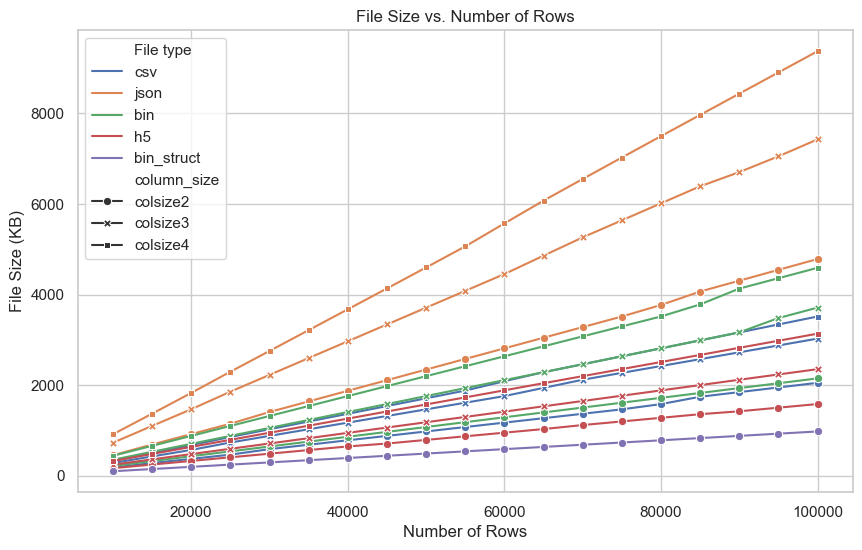

In [37]:
import os
import h5py

folders = [
    "../../csv2_colsize2", "../../csv2_colsize3", "../../csv2_colsize4",
    "../../JSON_colsize2", "../../JSON_colsize3", "../../JSON_colsize4",
    "../../old_bin_files/bin_colsize2", "../../old_bin_files/bin_colsize3", "../../old_bin_files/bin_colsize4",
    "../../HDF5_colsize2","../../HDF5_colsize3","../../HDF5_colsize4",
    "../../unstruct_bin_opt_buffer_colsize2"
]

data = []

for folder in folders:
    for file in os.listdir(folder): 
        filepath = os.path.join(folder, file)
        file_size = os.path.getsize(filepath) / 1024  
        extra_index = 0
        if file.endswith(".csv"):
            df = pd.read_csv(filepath)
            file_type = "csv"
        elif file.endswith(".json"):
            df = pd.read_json(filepath)
            file_type = "json"
        elif file.endswith(".bin"):  
            if folder != "../../unstruct_bin_opt_buffer_colsize2":
                file_type = "bin"
                extra_index = 2
            else:
                file_type = "bin_struct"
                extra_index = 3
        elif file.endswith(".h5"):
            with h5py.File(filepath, "r") as f:
                df = pd.DataFrame({"timestamp": f["timestamp"][:], "temperature": f["temperature"][:]})
            file_type = "h5"
        else:
            continue

        colsize = folder.split("_")[-1]
        num_rows = filepath.split("_")[3 + extra_index]
        data.append((folder, num_rows, file_size, file_type, colsize))

df_plot = pd.DataFrame(data, columns=["Folder", "Rows", "File Size (KB)", "File type", "column_size"])
display(df_plot)
df_plot["Rows"] = pd.to_numeric(df_plot["Rows"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x="Rows", y="File Size (KB)", hue="File type", style="column_size", markers = True, dashes=False)


plt.xlabel("Number of Rows")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Number of Rows")
plt.legend()
plt.savefig("wfile_Right.png", dpi = 1000, bbox_inches = "tight")
plt.show()


,Folder,Rows,File Size (KB),File type,column_size
0,../../csv2_colsize2,100000,2050.781250,csv,colsize2
1,../../csv2_colsize2,10000,178.240234,csv,colsize2
2,../../csv2_colsize2,15000,278.320312,csv,colsize2
3,../../csv2_colsize2,20000,371.093750,csv,colsize2
4,../../csv2_colsize2,25000,464.529297,csv,colsize2
...,...,...,...,...,...
242,../../unstruct_bin_opt_buffer_colsize2,75000,732.421875,bin_struct,colsize2
243,../../unstruct_bin_opt_buffer_colsize2,80000,781.250000,bin_struct,colsize2
244,../../unstruct_bin_opt_buffer_colsize2,85000,830.078125,bin_struct,colsize2
245,../../unstruct_bin_opt_buffer_colsize2,90000,878.906250,bin_struct,colsize2


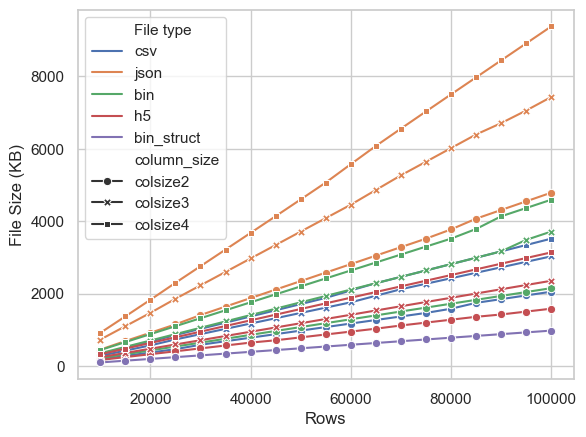

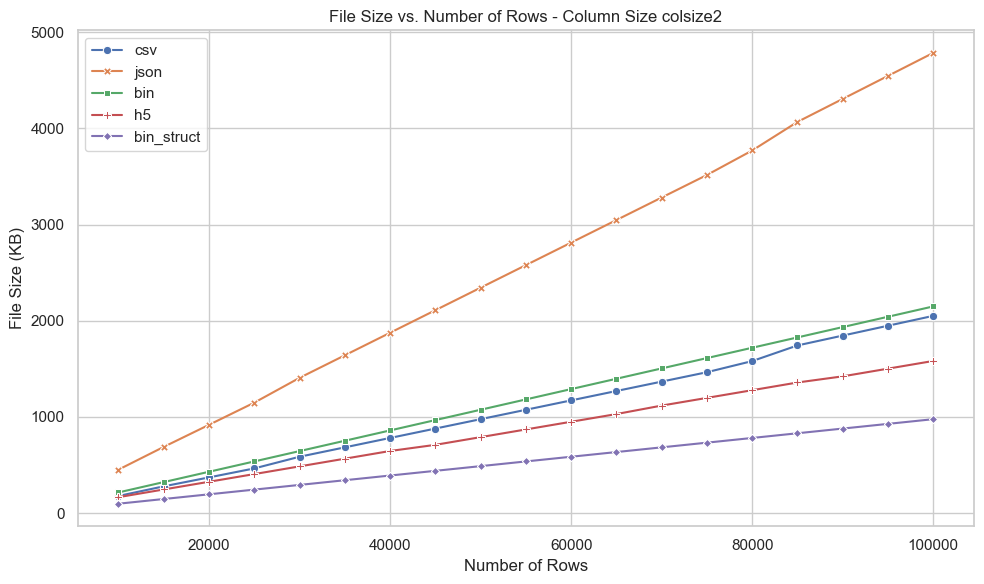

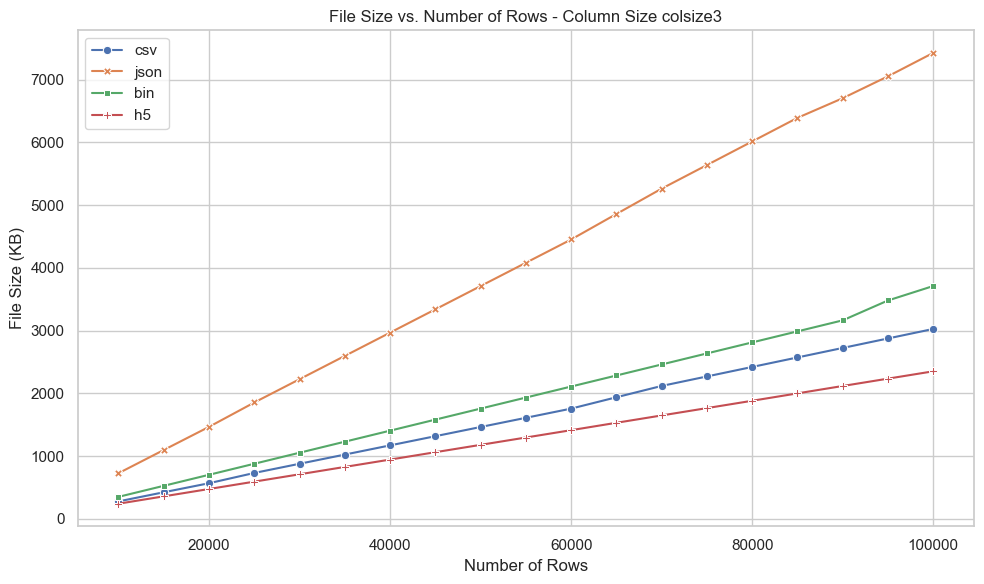

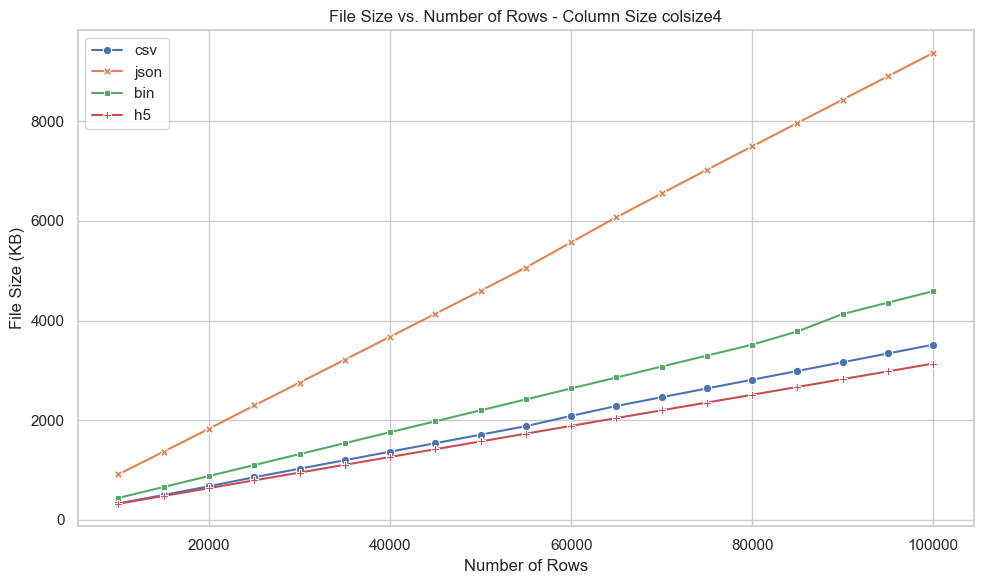

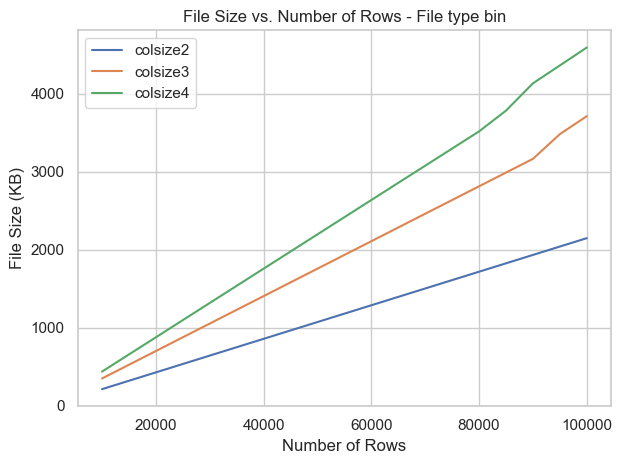

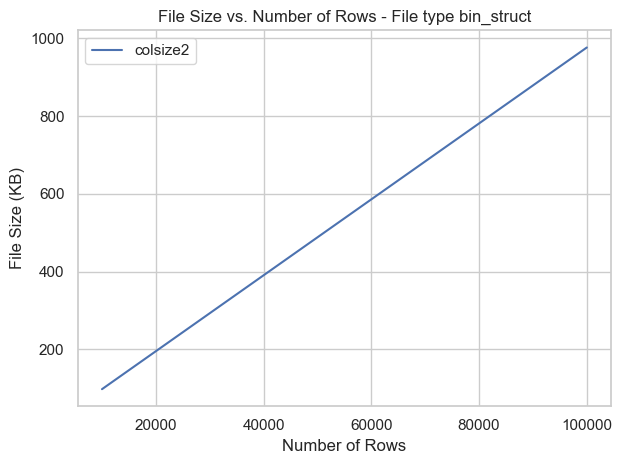

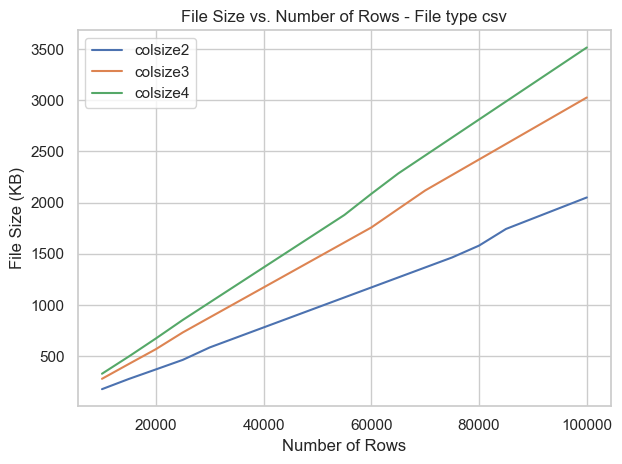

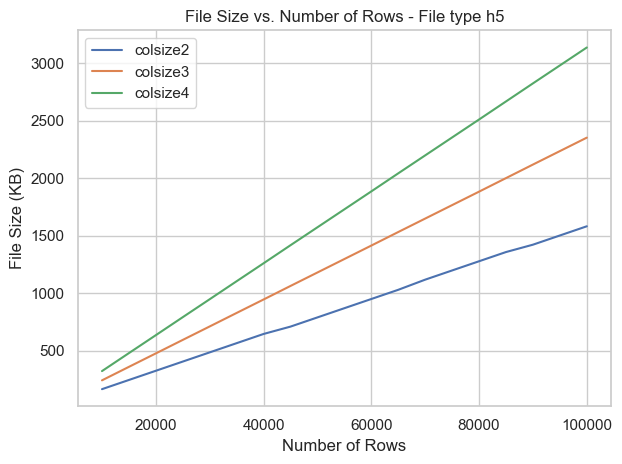

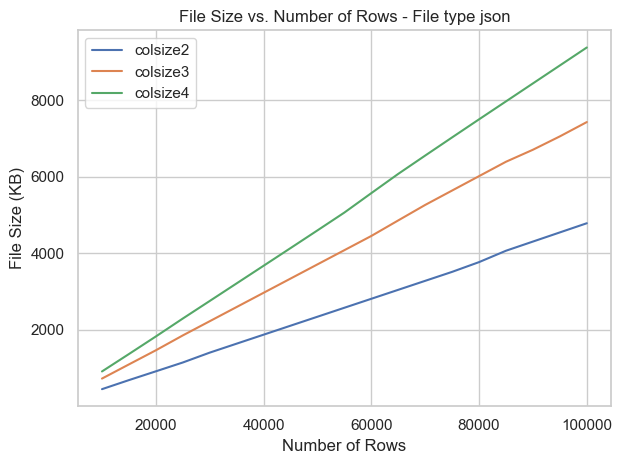

In [39]:
import os
import h5py #sometimes my juyter environment would forget that it imported these...

folders = [
    "../../csv2_colsize2", "../../csv2_colsize3", "../../csv2_colsize4",
    "../../JSON_colsize2", "../../JSON_colsize3", "../../JSON_colsize4",
    "../../old_bin_files/bin_colsize2", "../../old_bin_files/bin_colsize3", "../../old_bin_files/bin_colsize4",
    "../../HDF5_colsize2","../../HDF5_colsize3","../../HDF5_colsize4",
    "../../unstruct_bin_opt_buffer_colsize2"
]

data = []

for folder in folders:
    for file in os.listdir(folder): 
        filepath = os.path.join(folder, file)
        file_size = os.path.getsize(filepath) / 1024  
        index = 3
        if file.endswith(".csv"):
            df = pd.read_csv(filepath)
            file_type = "csv"
        elif file.endswith(".json"):
            df = pd.read_json(filepath)
            file_type = "json"
        elif file.endswith(".bin"):  
            #df = pd.DataFrame([line for line in open(filepath, "rb")])  
            if folder != "../../unstruct_bin_opt_buffer_colsize2":
                file_type = "bin"
            else:

                file_type = "bin_struct"
        elif file.endswith(".h5"):
            with h5py.File(filepath, "r") as f:
                df = pd.DataFrame({"timestamp": f["timestamp"][:], "temperature": f["temperature"][:]})
            file_type = "h5"

        colsize = folder.split("_")[-1]
        num_rows = file.split("_")[2]
        data.append((folder, num_rows, file_size, file_type, colsize))

df_plot = pd.DataFrame(data, columns=["Folder", "Rows", "File Size (KB)", "File type", "column_size"])
display(df_plot)
df_plot["Rows"] = pd.to_numeric(df_plot["Rows"])

sns.lineplot(data=df_plot, x="Rows", y="File Size (KB)", hue="File type", style="column_size", markers=True, dashes=False)

def plot_data_by_colsize(colsize):
    subset = df_plot[df_plot["column_size"] == colsize]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x="Rows", y="File Size (KB)", hue="File type", style="File type", markers=True, dashes=False)
    
    plt.xlabel("Number of Rows")
    plt.ylabel("File Size (KB)")
    plt.title(f"File Size vs. Number of Rows - Column Size {colsize}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each column size
for colsize in ["colsize2", "colsize3", "colsize4"]:
    plot_data_by_colsize(colsize)

file_types_df = df_plot.groupby("File type")

for category, data in file_types_df:
    sns.lineplot(data = data, x ="Rows", y= "File Size (KB)", hue = "column_size")
    plt.xlabel("Number of Rows")
    plt.ylabel("File Size (KB)")
    plt.title(f"File Size vs. Number of Rows - File type {category}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()